In [1]:
from tools import functions
from tools import constants

import pandas as pd 
import numpy as np 

import matplotlib.pyplot as plt
import matplotlib
plt.style.use("seaborn-poster")

# Importing KS observations

In [2]:
observations_directory = "/mnt/raid-cita/dtolgay/Observations"

kennicutt_1998 = pd.read_excel(f"{observations_directory}/kennicutt_1998.xlsx")
genzel_2010 = pd.read_excel(f"{observations_directory}/genzel_2010.xlsx")

kennicutt_1998

,source_name,D,log_sigma_HI,log_sigma_H2,log_sigma_gas,log_sigma_sfr,log_tau_dynamical,CO_sources2,HI_sources22,Halpha_sources
0,224,165.2,0.66,-0.58,0.68,-3.13,4.6,1,5,22
1,598,55.9,1.02,-0.71,1.03,-2.47,4.0,2,6,23
2,628,10.2,0.77,0.41,0.93,-2.18,NaN,"3, 4",7,"24, 25"
3,772,7.2,0.60,0.68,0.94,-2.84,7.9,5,8,26
4,925,8.9,0.85,0.05,0.91,-2.44,7.3,"2, 4",7,25
...,...,...,...,...,...,...,...,...,...,...
56,6217,3.0,0.73,1.16,1.29,-1.91,2.9,2,6,24
57,6503,4.9,0.61,0.53,0.89,-2.08,1.7,"3, 4",7,24
58,6643,3.4,0.85,0.77,1.11,-1.81,3.7,3,8,"24, 26"
59,6946,10.7,0.94,1.04,1.30,-1.88,3.5,"3, 4",21,"24, 25"


In [3]:
galaxy_name = "m12i_res7100_md"
galaxy_type = "zoom_in"
redshift = "0.0"

# galaxy_name = "m11i_r7100"
# galaxy_type = "zoom_in"
# redshift = "0.0"

# galaxy_name = "gal10"
# galaxy_type = "firebox"
# redshift = "0.0"


In [4]:
# Read cloudy_gas_txt 
cloudy_gas_particles_file_directory = f"/mnt/raid-cita/dtolgay/FIRE/post_processing_fire_outputs/skirt/runs_hden_radius/{galaxy_type}/z{redshift}/{galaxy_name}/trial1" 


# Define the column names based on your description
gas_column_names = [
    "x", 
    "y", 
    "z", 
    "smoothing_length", 
    "mass", 
    "metallicity", # Zsolar but will be converted to mass fraction in the future
    "temperature", 
    "vx", 
    "vy", 
    "vz", 
    "hden", 
    "radius", 
    "sfr", 
    "turbulence", 
    "density", 
    "mu_theoretical", 
    "average_sobolev_smoothingLength",
    "index", 
    "isrf"
]


gas_particles_df = pd.read_csv(
    f"{cloudy_gas_particles_file_directory}/cloudy_gas_particles.txt",
    delim_whitespace=True, 
    comment='#', 
    names=gas_column_names
)


# isrf of the gas particles can be zero, therefore set them equal to a very small number
gas_particles_df.loc[gas_particles_df["isrf"] == 0, "isrf"] = 1e-30    

# Convert metallicity to mass fraction from solar metallicity
gas_particles_df["metallicity"] *= constants.solar_metallicity  # Mass fraction 

# Converting density back to 1e10 Msolar / kpc^3 from gr/cm^3
# gas_particles_df["density"] *= (1 / (1e10 * constants.M_sun2gr)) * (constants.kpc2cm)**3  # 1e10 Msolar / kpc^3 
gas_particles_df["density"] /= (1e10 * constants.M_sun2gr / (constants.kpc2cm)**3)  # 1e10 Msolar / kpc^3


print(f"{cloudy_gas_particles_file_directory}/cloudy_gas_particles.txt read and dataframe is created!")


star_column_names = [
    "x",
    "y",
    "z",
    "vx",
    "vy",
    "vz",
    "metallicity",
    "mass",
    "age"
]

star_particles_df = pd.read_csv(
    f"{cloudy_gas_particles_file_directory}/comprehensive_star.txt",
    delim_whitespace=True, 
    comment='#', 
    names=star_column_names
)

print(f"{cloudy_gas_particles_file_directory}/comprehensive_star.txt read and dataframe is created!")


/mnt/raid-cita/dtolgay/FIRE/post_processing_fire_outputs/skirt/runs_hden_radius/zoom_in/z0.0/m12i_res7100_md/trial1/cloudy_gas_particles.txt read and dataframe is created!
/mnt/raid-cita/dtolgay/FIRE/post_processing_fire_outputs/skirt/runs_hden_radius/zoom_in/z0.0/m12i_res7100_md/trial1/comprehensive_star.txt read and dataframe is created!


In [5]:
# import inspect
# print(inspect.getsource(constants))

In [6]:
############################################################################################################################################

# h2 mass fraction is calculated by following Krumholz, and Gnedin (2011) 
# "A Comparison of Methods for Determining the Molecular Content of Model Galaxies by Krumholz, and Gnedin (2011)"

gas_particles_df["local_density_scale_height"] =  functions.local_density_scale_height_calculator(
    density_gas = np.array(gas_particles_df["density"]), 
    x_gas = np.array(gas_particles_df["x"]), 
    y_gas = np.array(gas_particles_df["y"]), 
    z_gas = np.array(gas_particles_df["z"]), 
    smoothing_length_gas = np.array(gas_particles_df["smoothing_length"])
) # pc 



h2_mass_fraction, gas_column_density, dust_optical_depth, scaled_radiation_field, s, dust_optical_depth = functions.h2_mass_fraction_calculator(
    local_density_scale_height = np.array(gas_particles_df["smoothing_length"]) / constants.kpc2pc, # kpc
    density = np.array(gas_particles_df["density"]), # 1e10 Msolar / kpc^3
    metallicity= np.array(gas_particles_df["metallicity"]),  # mass fraction  
    clumping_factor = 1
)

# Find molecular gas mass
gas_particles_df["h2_mass"] = h2_mass_fraction * gas_particles_df["mass"]

I am in the function local_density_scale_height_calculator
I am in the function h2_mass_fraction_calculator


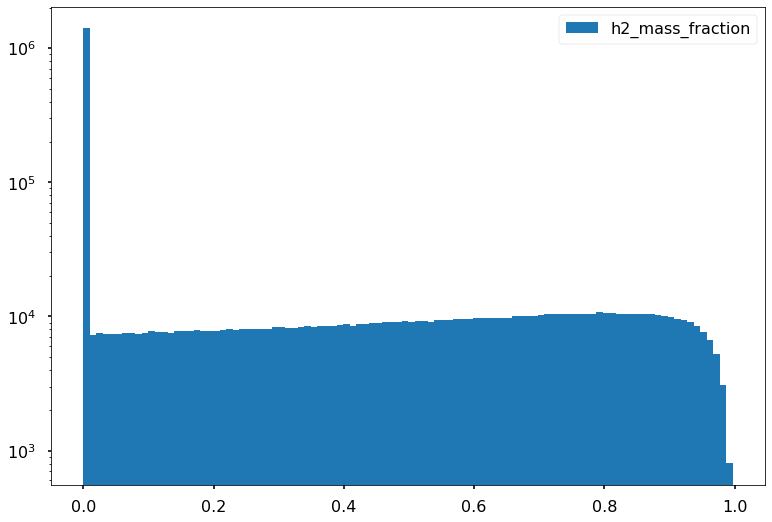

In [7]:
plt.hist(h2_mass_fraction, bins = 100, label="h2_mass_fraction")
plt.yscale("log")
plt.legend()
plt.show()

In [8]:
total_h2_mass = np.sum(h2_mass_fraction * gas_particles_df["mass"]) # Msolar 
total_sfr = np.sum(gas_particles_df["sfr"])

print(f"total_h2_mass: {np.log10(total_h2_mass)} --- total_sfr: {total_sfr}")

total_h2_mass: 9.70038163418807 --- total_sfr: 9.210631823644064


In [9]:
# Stellar mass - halo mass
print(f"stellar mass: {np.log10(np.sum(star_particles_df['mass']))}")

stellar mass: 10.831345557087587


In [10]:

print(len(gas_particles_df["local_density_scale_height"]))
print(len(gas_particles_df["smoothing_length"]))
print(len(gas_particles_df["average_sobolev_smoothingLength"]))


2270462
2270462
2270462


Calculating density gradient a la [Gensior et al. MNRAS (2020) ***495*** 195](https://watermark.silverchair.com/staa1184.pdf?token=AQECAHi208BE49Ooan9kkhW_Ercy7Dm3ZL_9Cf3qfKAc485ysgAAA3QwggNwBgkqhkiG9w0BBwagggNhMIIDXQIBADCCA1YGCSqGSIb3DQEHATAeBglghkgBZQMEAS4wEQQMUt65V02eM2im2QJNAgEQgIIDJwCHeFZ0UWnL_90Lz-xBgr2G_Pe5kQSFBUcU5MBC5ODsmV0KZdKRuoNKSXWIuPJGRKdns2KQERXl0q5y9oYDAUzk6jut32PpIFV10pfYnStLBWfYra8oNp4lf1I5_34VB49cYJULK--8X9AbNEGTGd6tqQe9xgRprC6N9Dt_c9pNNhjvMSZHSUSgWLarxV3MbqI3oxKu8zEoCZVxyA1IgRNOzyQUrkyc6kdbiDW2kxpnnTLQXp5p8aINcsD29RlqXYnRWAEBr0K37YhDbUcYVpprZqDvAZ9xnvnUnqA3IGzhO2aEVwHqm-bBvgPHAZf6TWNwXNA9XdSrsT7L1YbjQHvC61XPIw0wdCNQ8Mz8nexCwnOcObnQR39vwGTzMkPoXIet0hVLfskA-VdJVhezaq3XUAox7nTLGnW5uulDuqOORtA-Pg21rIkZxAji2HJQRmbQ1lJ_buRsWj7wGdTk94gHFehsF2sbTRnvHZxMvT-vBj3e0R4kt0s2k1vHdR7M16YPfYNKYKVJg8WH_hhTyKmCD9RInLVbwIhk30D6HuwAiHJ4drx-9gB4ZuAj96Px0n4rIG8LsSCwACIdLNTpSi3YkBXdKsCfHlCu_4YkEMEKXlHGZF1GhGoaHPIIKZw2_4Z2g_5YX8TZjTVxTCApBK9_Xz_mToL8ebIs5iQiWw9UrUmtcD6-ojGiVwwU4cPSq9Of8a_J3I8P2db9x2m60nAbMQhSRddViKJHpOIjbi40oyZC43uoE8Y1P8afU-fzKDmbioM34uG057Yr8IIqpWx_BWkMh6pZ8Y_k83Rid9qQpi0oCzqEwOsCwSoNC0sjiJWybJoJS0OpuVJiBJHBocAh2yeQG0Da2YofMt2-dY0bpn2SGg-Ap9ffvvQHx-InW620-CrweaG6Ex25-ZUoSkd5WEE0PTD6kh4xcPIhqVhN95xVsJA4cBC7NTR5d-hyNnGsY1H_Z-At0s99_mSZ1nYAT5ET3TAeDHgSjnJ8J1i6fVNqmCZKUXybjvHrshK4EKoAoHhDngKdImtbySYbt0SgEwULkP7elSon8d-b9Sn_gsnvBaFnQw)

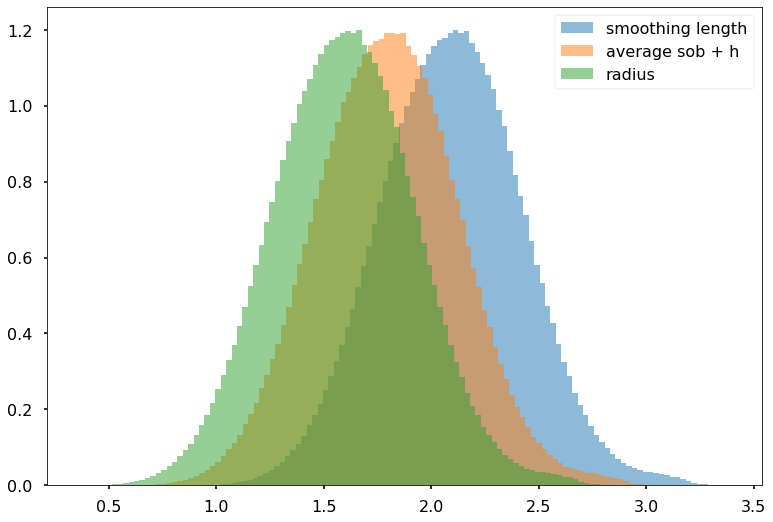

In [11]:
# plt.hist(np.log10(gas_particles_df["local_density_scale_height"]), bins = 100, alpha = 0.5, density = True, label="local density scale height")
plt.hist(np.log10(gas_particles_df["smoothing_length"]), bins = 100, alpha = 0.5, density = True, label="smoothing length")
plt.hist(np.log10(gas_particles_df["average_sobolev_smoothingLength"]), bins = 100, alpha = 0.5, density = True, label = "average sob + h")
plt.hist(np.log10(gas_particles_df["radius"]), bins = 100, alpha = 0.5, density = True, label = "radius")
plt.legend()
plt.show()

# Column Densities

## For each annulus

In [12]:
# Create annulus

R_max = 20e3

R_gas = np.sqrt(
    gas_particles_df["x"]**2 + gas_particles_df["y"]**2 + gas_particles_df["z"]**2
)

R_star = np.sqrt(
    star_particles_df["x"]**2 + star_particles_df["y"]**2 + star_particles_df["z"]**2
)

# Creating different annulus areas to categorizing the code in these corresponding categories and calculating the Lco in these annulus categorization
    # number_of_bins is the number of categorization
# number_of_bins = int(2*R_max + 1)
# number_of_bins = int(10*R_max + 1)  
number_of_bins = 101 # Number of annulus is number_of_bins - 1 


# There is Rmax/number_of_bins distance between two radius that divides annulus from each other
radius_boundaries_for_bins = np.linspace(0, R_max, number_of_bins) 
outer_radius_for_bins = radius_boundaries_for_bins[1:]                                                  # pc
inner_radius_for_bins = radius_boundaries_for_bins[:-1]                                                 # pc

# Annulus area is calculated in here. It is calculated by subtracting the area of big circle from smaller circle
annulus_area = np.pi * (np.power(outer_radius_for_bins,2) - np.power(inner_radius_for_bins,2))          # pc^2

# Categorization will be done in here. I will use numpy.digitize to categorize the R_gas and therefore other parameters. The reason for me to 
# do it is to find sigma_gas within this annulus and find the h2_mass_fraction (f_h2) in each of the annulus and find Xco and alfa_co in 
# each of the annulus. 

digitize_gas_bins = np.digitize(R_gas, radius_boundaries_for_bins)
digitize_star_bins = np.digitize(R_star, radius_boundaries_for_bins)
# With the above code now gas particles are categorized.
        
        
#### Finding surface densities for gas

surface_densities = [] #Initiate an empty array
surface_densities_per_kpc_square = []

for i in range(min(digitize_gas_bins), max(digitize_gas_bins)):
    
    indices_of_the_gas_particles_inside_annulus = np.where(digitize_gas_bins==i)[0]
    
    ###### gas mass
    
    total_gas_mass_inside_the_annulus = np.sum(
        gas_particles_df.iloc[indices_of_the_gas_particles_inside_annulus]["mass"]
    ) # Msolar    
    column_gas_density_inside_annulus = total_gas_mass_inside_the_annulus / (annulus_area[i]) # Msolar / pc^2
    column_gas_density_inside_annulus_per_kpc_square = total_gas_mass_inside_the_annulus / (annulus_area[i]*1e-6) # Msolar / kpc^2
    
    ###### H2
    
    total_molecular_gas_mass_inside_the_annulus = np.sum(
        gas_particles_df.iloc[indices_of_the_gas_particles_inside_annulus]["h2_mass"]
    ) # Msolar    
    column_molecular_gas_density_inside_annulus = total_molecular_gas_mass_inside_the_annulus / (annulus_area[i]) # Msolar / pc^2
    column_molecular_gas_density_inside_annulus_per_kpc_square = total_molecular_gas_mass_inside_the_annulus / (annulus_area[i]*1e-6) # Msolar / kpc^2
    
    ###### SFR
    
    total_sfr_inside_the_annulus = np.sum(
        gas_particles_df.iloc[indices_of_the_gas_particles_inside_annulus]["sfr"]
    ) # Msolar / year
    sfr_column_density_inside_annulus = total_sfr_inside_the_annulus / (annulus_area[i]*1e-6) # Msolar year^-1 kpc^-2
    
    
    surface_densities.append((
        column_gas_density_inside_annulus, 
        column_molecular_gas_density_inside_annulus, 
        sfr_column_density_inside_annulus
    ))
    
    surface_densities_per_kpc_square.append((
        column_gas_density_inside_annulus_per_kpc_square, 
        column_molecular_gas_density_inside_annulus_per_kpc_square, 
        sfr_column_density_inside_annulus        
    ))
    

#### Finding surface densities for star

star_surface_densities = []

for i in range(min(digitize_star_bins), max(digitize_star_bins)):
    
    indices_of_the_star_particles_inside_annulus = np.where(digitize_star_bins==i)[0]
    
    ###### stellar mass
    
    total_star_mass_inside_the_annulus = np.sum(
        star_particles_df.iloc[indices_of_the_star_particles_inside_annulus]["mass"]
    ) # Msolar    
    column_star_density_inside_annulus_per_kpc_square = total_star_mass_inside_the_annulus / (annulus_area[i]*1e-6) # Msolar / kpc^2
        
    
    star_surface_densities.append(
        column_star_density_inside_annulus_per_kpc_square
    )
    
    
surface_densities = np.array(surface_densities)
surface_densities_per_kpc_square = np.array(surface_densities_per_kpc_square)

star_surface_densities = np.array(star_surface_densities)

In [13]:
# indices = np.where(digitize_gas_bins==3)[0]

# plt.hist2d(
#         x=gas_particles_df.iloc[indices]["x"],
#         y=gas_particles_df.iloc[indices]["y"],
#         bins=500,
#         norm=matplotlib.colors.LogNorm(),
#         range=[[-R_max, R_max], [-R_max, R_max]]
#     )
# plt.show()

/tmp/ipykernel_2116085/2796804673.py:1: RuntimeWarning: divide by zero encountered in log10
  plt.scatter(np.log10(surface_densities[:,0]), np.log10(surface_densities[:,2]), label = f"all gas -- my data, {galaxy_name}")
/tmp/ipykernel_2116085/2796804673.py:2: RuntimeWarning: divide by zero encountered in log10
  plt.scatter(np.log10(surface_densities[:,1]), np.log10(surface_densities[:,2]), label = f"molecular gas -- my data, {galaxy_name}")


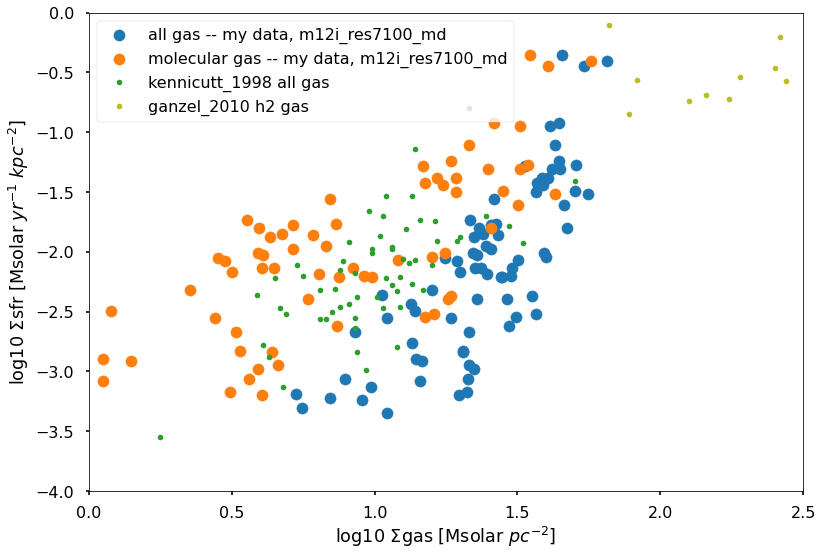

In [14]:
plt.scatter(np.log10(surface_densities[:,0]), np.log10(surface_densities[:,2]), label = f"all gas -- my data, {galaxy_name}")
plt.scatter(np.log10(surface_densities[:,1]), np.log10(surface_densities[:,2]), label = f"molecular gas -- my data, {galaxy_name}")

# plt.scatter(FIRE_eyeballing[:,0], FIRE_eyeballing[:,1], color="tab:Red", label = "fire_eyeballing")
plt.plot(kennicutt_1998["log_sigma_gas"], kennicutt_1998["log_sigma_sfr"], '.', color="tab:Green", label = "kennicutt_1998 all gas")
plt.plot(genzel_2010["log_sigma_mol"], genzel_2010["log_sigma_sfr"], '.', color="tab:Olive", label = "ganzel_2010 h2 gas")

plt.xlabel("log10 Σgas [Msolar $pc^{-2}$]")
plt.ylabel("log10 Σsfr [Msolar $yr^{-1}$ $kpc^{-2}$]")
plt.ylim([-4, 0])
plt.xlim([0, 2.5])
plt.legend()
plt.show()

/tmp/ipykernel_2116085/1609587256.py:8: RuntimeWarning: divide by zero encountered in log10
  plt.scatter(np.log10(surface_densities_per_kpc_square[:,0]), np.log10(surface_densities_per_kpc_square[:,2]), label = f"all gas -- my data, {galaxy_name}")
/tmp/ipykernel_2116085/1609587256.py:9: RuntimeWarning: divide by zero encountered in log10
  plt.scatter(np.log10(surface_densities_per_kpc_square[:,1]), np.log10(surface_densities_per_kpc_square[:,2]), label = f"molecular gas -- my data, {galaxy_name}")


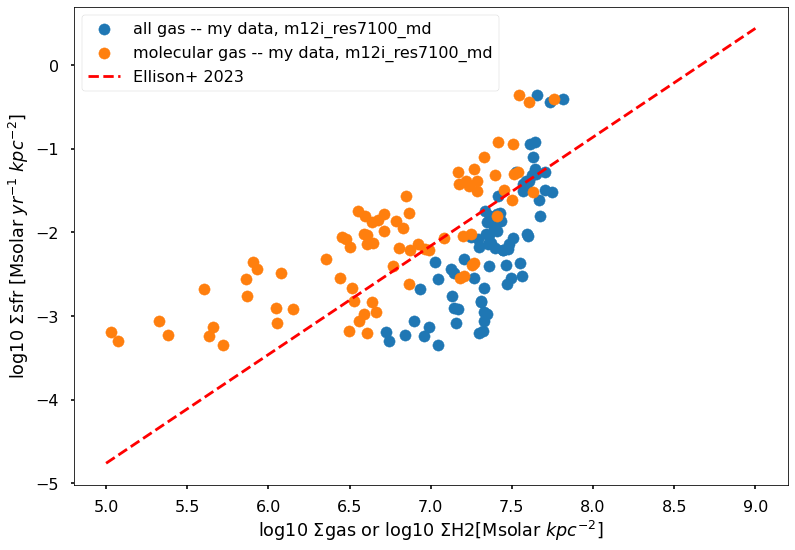

In [15]:
# Formula from the Ellison 2023 The almaquest survey paper: https://ui.adsabs.harvard.edu/abs/2024MNRAS.52710201E/abstract
# Figure 1

log_sigma_h2_ellison = np.linspace(5, 9, 100)
log_sigma_sfr_ellison = -11.26 + 1.3 * log_sigma_h2_ellison


plt.scatter(np.log10(surface_densities_per_kpc_square[:,0]), np.log10(surface_densities_per_kpc_square[:,2]), label = f"all gas -- my data, {galaxy_name}")
plt.scatter(np.log10(surface_densities_per_kpc_square[:,1]), np.log10(surface_densities_per_kpc_square[:,2]), label = f"molecular gas -- my data, {galaxy_name}")


plt.plot(log_sigma_h2_ellison, log_sigma_sfr_ellison, 'r--', label = "Ellison+ 2023")

plt.xlabel("log10 Σgas or log10 ΣH2[Msolar $kpc^{-2}$]")
plt.ylabel("log10 Σsfr [Msolar $yr^{-1}$ $kpc^{-2}$]")
# plt.ylim([-4, 0])
# plt.xlim([0, 2.5])
plt.legend()
plt.show()


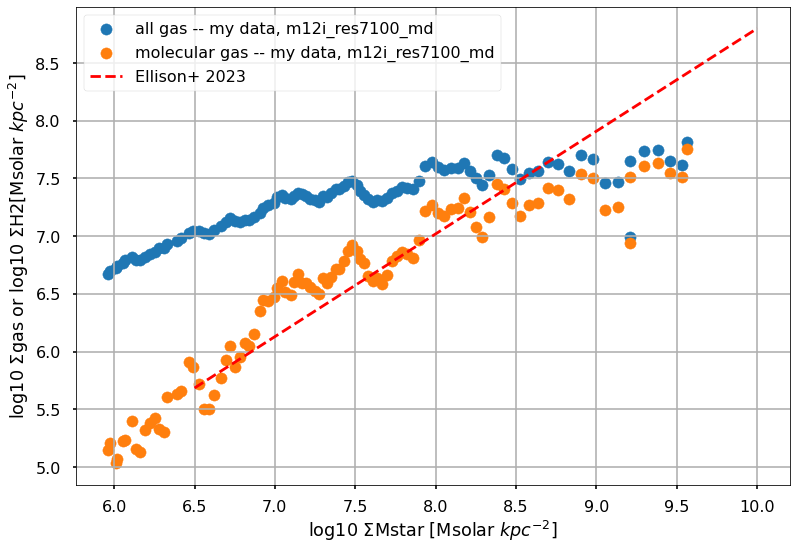

In [16]:
# Formula from the Ellison 2023 The almaquest survey paper: https://ui.adsabs.harvard.edu/abs/2024MNRAS.52710201E/abstract
# Figure 1

log_sigma_star_mass_ellison = np.linspace(6.5, 10, 100)
log_sigma_h2_ellison = -0.1 + 0.89 * log_sigma_star_mass_ellison


plt.scatter(np.log10(star_surface_densities), np.log10(surface_densities_per_kpc_square[:,0]), label = f"all gas -- my data, {galaxy_name}")
plt.scatter(np.log10(star_surface_densities), np.log10(surface_densities_per_kpc_square[:,1]), label = f"molecular gas -- my data, {galaxy_name}")


plt.plot(log_sigma_star_mass_ellison, log_sigma_h2_ellison, 'r--', label = "Ellison+ 2023")

plt.xlabel("log10 ΣMstar [Msolar $kpc^{-2}$]")
plt.ylabel("log10 Σgas or log10 ΣH2[Msolar $kpc^{-2}$]")
# plt.ylim([-4, 0])
# plt.xlim([0, 2.5])
plt.grid(True)
plt.legend()
plt.show()


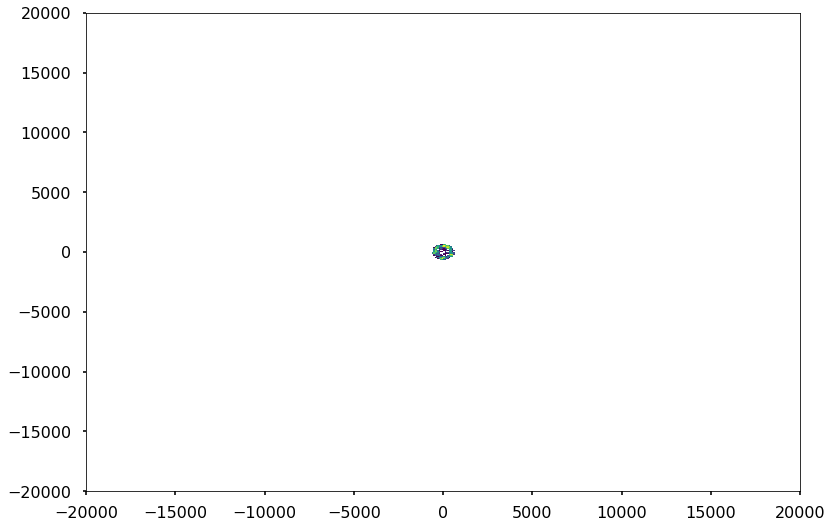

In [17]:
R_max = 20e3

indices = np.where(digitize_gas_bins==3)[0]

plt.hist2d(
        x=gas_particles_df.iloc[indices]["x"],
        y=gas_particles_df.iloc[indices]["y"],
        bins=500,
        norm=matplotlib.colors.LogNorm(),
        range=[[-R_max, R_max], [-R_max, R_max]]
    )
plt.show()

# Reading actual gas particles

In [18]:
# galaxy_name = "m12i_res7100_md"
# snapshot_number = 600

# print("\n\nsnapshot_number: ", snapshot_number)
# print("All gas particles are considered")
# print("galaxy_name: ", galaxy_name)


# from tools import readsnap, functions, constants, plotting_routines
# import numpy as np
# import os

# snap_dir_file_path = f"/fs/lustre/project/murray/FIRE/FIRE_2/{galaxy_name}/output"


# # Writing snapshot_number in 3 significant digits
# # snapshot_number = int(snapshot_number)
# snapshot_number = '%03d' %snapshot_number


# # Reading snapshot for gas_particles, star_particles, and dark_matter_particles
# gas_particles           = readsnap.readsnap(snap_dir_file_path, snapshot_number, 0, cosmological=1)
# star_particles          = readsnap.readsnap(snap_dir_file_path, snapshot_number, 4, cosmological=1)
# #    dm_particles            = readsnap.readsnap(snap_dir_file_path, snapshot_number, 1, cosmological=1)

# # Values for particles 
# # http://www.tapir.caltech.edu/~phopkins/Site/GIZMO_files/gizmo_documentation.html
#     # Gas Particles 
# x_gas                           = gas_particles['p'][:,0]   # [kpc]
# y_gas                           = gas_particles['p'][:,1]   # [kpc]
# z_gas                           = gas_particles['p'][:,2]   # [kpc]

# vx_gas                          = gas_particles['v'][:,0]   # [km/sec]
# vy_gas                          = gas_particles['v'][:,1]   # [km/sec]
# vz_gas                          = gas_particles['v'][:,2]   # [km/sec]

# mass_gas                        = gas_particles['m']        # [1e10 M☉]

# density_gas                     = gas_particles['rho']      # [6.77*1e-22 g/cm^3] ~ [1e10 M☉/kpc^3]

# smoothing_length_gas             = gas_particles['h']        # [kpc]

# star_formation_rate             = gas_particles['sfr']      # M☉/year -> gizmo documentation -> reading snapshots -> StarFormationRate

# internal_energy_gas             = gas_particles['u']        # [km^2 s^-2] Use it to compute temperature
# # Conveting internal energy to m^2 s^-2:
# internal_energy_gas             = internal_energy_gas * 1e6 # [m^2 s^-2] 

# neutral_hydrogen_fraction_gas   = gas_particles['nh']       # fraction of hydrogen that is neutral

# electron_abundace_gas           = gas_particles['ne']       # mean number of free electrons per hydrogen nucleus

# ### Check the link http://www.tapir.caltech.edu/~phopkins/Site/GIZMO_files/gizmo_documentation.html#snaps-units to look what metallicity is:
# ### Reading snapshots -> Metallicity
# ### or check https://bitbucket.org/awetzel/gizmo_analysis/src/master/gizmo_io.py

# metallicity_gas      = gas_particles['z'][:,0]              # "total" metal mass "fraction?" (everything not H, He)  

# # metallicity_gas [unitless]
# # H_mass_fraction     = gas_particles['z'][:,1]
# He_mass_fraction    = gas_particles['z'][:,1]

# # At high metallicities H_mass_fraction can be negative. In order to prevent this I will set negative values to zero.
# # H_mass_fraction     = 1 - metallicity_gas - He_mass_fraction    
# # H_mass_fraction[H_mass_fraction<0] = 0


# # H_mass_fraction     = gas_particles['z'][:,1]      # The column ordering for the atoms are probably wrong.        
# # He_mass_fraction    = gas_particles['z'][:,2]
# # C_mass_fraction     = gas_particles['z'][:,3]
# # N_mass_fraction     = gas_particles['z'][:,4]
# # O_mass_fraction     = gas_particles['z'][:,5]
# # Ne_mass_fraction    = gas_particles['z'][:,6]
# # Mg_mass_fraction    = gas_particles['z'][:,7]
# # Si_mass_fraction    = gas_particles['z'][:,8]
# # S_mass_fraction     = gas_particles['z'][:,9]
# # Ca_mass_fraction    = gas_particles['z'][:,10]
# # Fe_mass_fraction    = gas_particles['z'][:,11]


#     # Star Particles 
# x_star  = star_particles['p'][:,0]          # [kpc]
# y_star  = star_particles['p'][:,1]          # [kpc]
# z_star  = star_particles['p'][:,2]          # [kpc]

# vx_star = star_particles['v'][:,0]          # [km/sec]
# vy_star = star_particles['v'][:,1]          # [km/sec]
# vz_star = star_particles['v'][:,2]          # [km/sec]

# scale_factor_star = star_particles['age']   # a(t) = 1/(1+z)

# mass_star = star_particles['m']             # [1e10 M☉]


# # Reading Header to get scale_factor, hubble_run, and redshift information 
# header_info = readsnap.readsnap(snap_dir_file_path, snapshot_number, 0, header_only=1)
# hubble      = header_info['hubble']
# redshift    = header_info['redshift']   
# time        = header_info['time']    

# print("redshift: ", redshift)


# ############################################################################################################################################

# # TODO: Delete
# # I set metallicity of gas particles equal to the solar metallicity. This is being done to check the Krumholz methadology.
# # print("\n\nMETALLICITY FIXED TO SOLAR METALLICITY\n\n")
# # metallicity_gas.fill(constants.solar_metallicity)

# ############################################################################################################################################

# # # Reading Most Massive Halo snapshot to get several parameters
# # mass_of_MMH, x_MMH_center, y_MMH_center, z_MMH_center = functions.finding_mass_and_coordinates_of_the_halo_with_most_particle_ahf(snapshot_dir=halo_finder_file_path, 
# #                                                                                                                                   snapshot_number=snapshot_number)

# #     # The positions and mass of the Halo is in comoving units. To make everything on physical units the below code is written
# # mass_of_MMH    = mass_of_MMH * 1./hubble        # [M☉]
# # x_MMH_center   = x_MMH_center * time/hubble     # [kpc]
# # y_MMH_center   = y_MMH_center * time/hubble     # [kpc]
# # z_MMH_center   = z_MMH_center * time/hubble     # [kpc]


# # # The purpose of this portion of the code is to check if there is any discontunity
# # vx_MMH_center, vy_MMH_center, vz_MMH_center = functions.finding_velocity_of_the_halo_with_most_particle_ahf(snapshot_dir=halo_finder_file_path, 
# #                                                                                                             snapshot_number=snapshot_number)
# # # Velocity is in peculiar components [km/s]

# ############################################################################################################################################

# # Most massive halo with Rockstar Halo Finder Code

# mass_of_MMH, x_MMH_center, y_MMH_center, z_MMH_center, vx_MMH_center, vy_MMH_center, vz_MMH_center, ID, DescID \
#                 = functions.halo_with_most_particles_rockstar(rockstar_snapshot_dir=halo_finder_file_path, 
#                                                               snapshot_number=snapshot_number,
#                                                               time = time,
#                                                               hubble = hubble)
# # Units
# # ----
# # mass_of_MMH [M☉]
# # x_MMH_center [kpc]
# # y_MMH_center [kpc]
# # z_MMH_center [kpc]
# # vx_MMH_center [km/s]
# # vy_MMH_center [km/s]
# # vz_MMH_center [km/s]

# ############################################################################################################################################    

# # Chancing the position of the origin. The new origin position is the center of mass of the most massive halo
# x_gas, y_gas, z_gas     = functions.change_origin(x=x_gas, 
#                                                   y=y_gas, 
#                                                   z=z_gas, 
#                                                   x_halo_center=x_MMH_center, 
#                                                   y_halo_center=y_MMH_center, 
#                                                   z_halo_center=z_MMH_center)

# vx_gas_MMH_sub, vy_gas_MMH_sub, vz_gas_MMH_sub  = functions.change_origin(x=vx_gas, 
#                                                                           y=vy_gas, 
#                                                                           z=vz_gas, 
#                                                                           x_halo_center=vx_MMH_center, 
#                                                                           y_halo_center=vy_MMH_center, 
#                                                                           z_halo_center=vz_MMH_center)



# x_star, y_star, z_star   = functions.change_origin(x=x_star, 
#                                                    y=y_star, 
#                                                    z=z_star, 
#                                                    x_halo_center=x_MMH_center, 
#                                                    y_halo_center=y_MMH_center, 
#                                                    z_halo_center=z_MMH_center)

# vx_star_MMH_sub, vy_star_MMH_sub, vz_star_MMH_sub = functions.change_origin(x=vx_star, 
#                                                                             y=vy_star, 
#                                                                             z=vz_star, 
#                                                                             x_halo_center=vx_MMH_center, 
#                                                                             y_halo_center=vy_MMH_center, 
#                                                                             z_halo_center=vz_MMH_center)

# ############################################################################################################################################

# # Filtering the code to increase its speed
#     # To increase the speed of the code I will only consider 20 kpc radius
# R_max = 20.0

#     # Finding the distance of gas particles from the center of the MMH
# R_gas   = np.sqrt(np.power(x_gas,2) + np.power(y_gas,2) + np.power(z_gas,2))
# R_star  = np.sqrt(np.power(x_star,2) + np.power(y_star,2) + np.power(z_star,2))

#     # Determining the indices that satisfy R_gas < R_max
# R_gas_smaller_than_Rmax_indices = np.where(R_gas < R_max)
# R_gas_smaller_than_Rmax_indices = R_gas_smaller_than_Rmax_indices[0] # indices are the zeroth element of the np.where() function

#     # Determining the indices that satisfy R_star < R_max
# R_star_smaller_than_Rmax_indices = np.where(R_star < R_max)
# R_star_smaller_than_Rmax_indices = R_star_smaller_than_Rmax_indices[0]

# ############################################################################################################################################

# # To increase the computation efficiency I will limit my attention to the particles within R_max from the center of the mmh 

# # Gas Particles
# x_gas                           = x_gas[R_gas_smaller_than_Rmax_indices]
# y_gas                           = y_gas[R_gas_smaller_than_Rmax_indices]
# z_gas                           = z_gas[R_gas_smaller_than_Rmax_indices]    

# R_gas                           = R_gas[R_gas_smaller_than_Rmax_indices]

# vx_gas                          = vx_gas[R_gas_smaller_than_Rmax_indices]
# vy_gas                          = vy_gas[R_gas_smaller_than_Rmax_indices]
# vz_gas                          = vz_gas[R_gas_smaller_than_Rmax_indices]

# vx_gas_MMH_sub                  = vx_gas_MMH_sub[R_gas_smaller_than_Rmax_indices]
# vy_gas_MMH_sub                  = vy_gas_MMH_sub[R_gas_smaller_than_Rmax_indices]
# vz_gas_MMH_sub                  = vz_gas_MMH_sub[R_gas_smaller_than_Rmax_indices]


# mass_gas                        = mass_gas[R_gas_smaller_than_Rmax_indices]

# density_gas                     = density_gas[R_gas_smaller_than_Rmax_indices]

# smoothing_length_gas             = smoothing_length_gas[R_gas_smaller_than_Rmax_indices]

# star_formation_rate             = star_formation_rate[R_gas_smaller_than_Rmax_indices] 

# metallicity_gas                 = metallicity_gas[R_gas_smaller_than_Rmax_indices]
# He_mass_fraction                = He_mass_fraction[R_gas_smaller_than_Rmax_indices]
# # H_mass_fraction         = H_mass_fraction[R_gas_smaller_than_Rmax_indices]


# internal_energy_gas             = internal_energy_gas[R_gas_smaller_than_Rmax_indices]       

# neutral_hydrogen_fraction_gas   = neutral_hydrogen_fraction_gas[R_gas_smaller_than_Rmax_indices]      

# electron_abundace_gas           = electron_abundace_gas[R_gas_smaller_than_Rmax_indices]      


# # Star Particles
# x_star                  = x_star[R_star_smaller_than_Rmax_indices]
# y_star                  = y_star[R_star_smaller_than_Rmax_indices]
# z_star                  = z_star[R_star_smaller_than_Rmax_indices]

# vx_star                 = vx_star[R_star_smaller_than_Rmax_indices]
# vy_star                 = vy_star[R_star_smaller_than_Rmax_indices]
# vz_star                 = vz_star[R_star_smaller_than_Rmax_indices]

# vx_star_MMH_sub         = vx_star_MMH_sub[R_star_smaller_than_Rmax_indices]
# vy_star_MMH_sub         = vy_star_MMH_sub[R_star_smaller_than_Rmax_indices]
# vz_star_MMH_sub         = vz_star_MMH_sub[R_star_smaller_than_Rmax_indices]

# scale_factor_star       = scale_factor_star[R_star_smaller_than_Rmax_indices]

# mass_star               = mass_star[R_star_smaller_than_Rmax_indices] 


# ############################################################################################################################################

# # Rotating the coordinate system such that z axis coincide with the z axis of the net angular momentum of star particles
#     # Finding the net angular momentum of the star particles inside the most massive halo and within R_max distance to the center of mass of MMH 

# # L_star = functions.net_angular_momentum(mass=mass_star, 
# #                                         rx=x_star,
# #                                         ry=y_star, 
# #                                         rz=z_star, 
# #                                         vx=vx_star, 
# #                                         vy=vy_star, 
# #                                         vz=vz_star) 
# #                                    # lx, ly, and lz are the indices 0, 1, and 2 respectively the net angular momentum of star particles

# L_gas = functions.net_angular_momentum(mass=mass_gas, 
#                                         rx=x_gas,
#                                         ry=y_gas, 
#                                         rz=z_gas, 
#                                         vx=vx_gas_MMH_sub, 
#                                         vy=vy_gas_MMH_sub, 
#                                         vz=vz_gas_MMH_sub) 
#                                    # lx, ly, and lz are the indices 0, 1, and 2 respectively the net angular momentum of gas particles

# # L unit: [1e10 M☉ kpc km / sec]


#     # Finding the angles between coordinate axis and net angular momentum
# theta, phi = functions.finding_the_angles_between_current_coordinate_system_and_net_angular_momentum(L=L_gas)
# # theta [radian]
# # phi   [radian]


#     # Rotating the coordinate system such that z axis of the net angular momentum coincides with the positive z axis of the new coordinate system
# x_star, y_star, z_star = functions.rotating_coordinate_system_along_net_angular_momentum(theta=theta, 
#                                                                                          phi=phi, 
#                                                                                          vectorx=x_star, 
#                                                                                          vectory=y_star, 
#                                                                                          vectorz=z_star)


# vx_star, vy_star, vz_star = functions.rotating_coordinate_system_along_net_angular_momentum(theta=theta, 
#                                                                                             phi=phi, 
#                                                                                             vectorx=vx_star, 
#                                                                                             vectory=vy_star, 
#                                                                                             vectorz=vz_star)


# x_gas, y_gas, z_gas = functions.rotating_coordinate_system_along_net_angular_momentum(theta=theta, 
#                                                                                       phi=phi,
#                                                                                       vectorx=x_gas,
#                                                                                       vectory=y_gas,
#                                                                                       vectorz=z_gas)

# vx_gas, vy_gas, vz_gas = functions.rotating_coordinate_system_along_net_angular_momentum(theta=theta, 
#                                                                                          phi=phi,
#                                                                                          vectorx=vx_gas,
#                                                                                          vectory=vy_gas,
#                                                                                          vectorz=vz_gas)




In [19]:
# density_gas_unit_converted = 1e10 * density_gas / (constants.kpc2pc)**3  # Msolar / pc^3

In [20]:
# # Create annulus

# R_max = 20

# # Creating different annulus areas to categorizing the code in these corresponding categories and calculating the Lco in these annulus categorization
#     # number_of_bins is the number of categorization
# # number_of_bins = int(2*R_max + 1)
# number_of_bins = int(10*R_max + 1)  # Number of annulus is number_of_bins - 1 

#     # There is Rmax/number_of_bins distance between two radius that divides annulus from each other
# radius_boundaries_for_bins = np.linspace(0, R_max, number_of_bins) 
# outer_radius_for_bins = radius_boundaries_for_bins[1:]                                                  # kpc
# inner_radius_for_bins = radius_boundaries_for_bins[:-1]                                                 # kpc

#     # Annulus area is calculated in here. It is calculated by subtracting the area of big circle from smaller circle
# annulus_area = np.pi * (np.power(outer_radius_for_bins,2) - np.power(inner_radius_for_bins,2) )         # kpc^2


#     # Categorization will be done in here. I will use numpy.digitize to categorize the R_gas and therefore other parameters. The reason for me to 
#     # do it is to find sigma_gas within this annulus and find the h2_mass_fraction (f_h2) in each of the annulus and find Xco and alfa_co in 
#     # each of the annulus. 

#         # Firstly I will limit my arrays that to values that are smaller than R_max

# digitize_gas_bins = np.digitize(R_gas, radius_boundaries_for_bins)
#         # With the above code now gas particles are categorized. I will use this in order to take the average of same regions. (Maybe I will do
#         # more than averaging)
        
        
# digitize_gas_bins
# len(annulus_area)

In [21]:
# import matplotlib

# # plt.hist2d(
# #         x=x_gas,
# #         y=y_gas,
# #         bins=500,
# #         norm=matplotlib.colors.LogNorm(),
# #         range=[[-R_max, R_max], [-R_max, R_max]]
# #     )
# # plt.show()


# plt.hist2d(
#         x=gas_particles_df["x"],
#         y=gas_particles_df["y"],
#         bins=500,
#         norm=matplotlib.colors.LogNorm(),
#         range=[[-R_max, R_max], [-R_max, R_max]]
#     )
# plt.show()

In [22]:
# gas_particles_df

In [23]:
# column_densities = [] #Initiate an empty array

# for i in range(len(annulus_area)):
    
#     indices_of_the_gas_particles_inside_annulus = np.where(digitize_gas_bins==i)[0]
    
#     total_gas_mass_inside_the_annulus = np.sum(mass_gas[indices_of_the_gas_particles_inside_annulus]) * 1e10 # Msolar
#     column_density_inside_annulus = total_gas_mass_inside_the_annulus / (annulus_area[i] * constants.kpc2pc) # Msolar / pc^2
    
#     total_sfr_inside_the_annulus = np.sum(sfr_gas[indices_of_the_gas_particles_inside_annulus]) # Msolar / year
#     sfr_column_density_inside_annulus = total_sfr_inside_the_annulus / (annulus_area[i]) # Msolar year^-1 kpc^-2
    
#     column_densities.append((column_density_inside_annulus, sfr_column_density_inside_annulus))
    
# column_densities = np.array(column_densities)

In [24]:
# plt.plot(np.log10(column_densities[:,0]), np.log10(column_densities[:,1]), '.')
# plt.xlabel("log10 Σgas [Msolar $pc^{-2}$]")
# plt.ylabel("log10 Σsfr [Msolar $yr^{-1}$ $kpc^{-2}$]")
# plt.show()

In [25]:
# plt.hist(density_gas_unit_converted, bins=1000, label="Reading FIRE", alpha = 0.5)
# plt.hist(gas_particles_df["density"], bins=1000, label="Reading cloudy gas particles", alpha = 0.5)
# plt.xscale("log")
# plt.yscale("log")
# plt.legend()
# plt.show()

In [26]:
# gas_particles_df.keys()

In [27]:
# gas_particles.keys()

# density_gas = gas_particles["rho"]
# sfr_gas = gas_particles["sfr"] # Msolar 

In [28]:
# plt.hist(gas_particles["rho"], bins = 100, label="actual fire", alpha = 0.5)
# plt.hist(gas_particles_df["density"], bins=100, label="cloudy gas file", alpha = 0.5)
# plt.yscale("log")
# plt.xscale("log")
# plt.legend()
# plt.show()